In [26]:
%matplotlib inline
from sklearn import datasets, model_selection, metrics
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import falkon
assert torch.cuda.is_available()


In [27]:
! pip freeze | grep torch

torch==2.0.0
torchaudio==2.0.0
torchvision==0.15.0


In [28]:
X, Y = datasets.fetch_california_housing(return_X_y=True)
num_train = int(X.shape[0] * 0.8)
num_test = X.shape[0] - num_train
shuffle_idx = np.arange(X.shape[0])
np.random.shuffle(shuffle_idx)
train_idx = shuffle_idx[:num_train]
test_idx = shuffle_idx[num_train:]

Xtrain, Ytrain = X[train_idx], Y[train_idx]
Xtest, Ytest = X[test_idx], Y[test_idx]

print(Xtrain.shape)
print(Xtest.shape)

Xtrain = torch.from_numpy(Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1])).to(dtype=torch.float32)
Xtest = torch.from_numpy(Xtest).to(dtype=torch.float32)
Ytrain = torch.from_numpy(Ytrain).to(dtype=torch.float32)
Ytest = torch.from_numpy(Ytest).to(dtype=torch.float32)

print(Xtrain.shape)
# print(Xtest.shape)

(16512, 8)
(4128, 8)
torch.Size([16512, 8])


In [29]:
# z-score normalization
train_mean = Xtrain.mean(0, keepdim=True)
train_std = Xtrain.std(0, keepdim=True)
Xtrain -= train_mean
Xtrain /= train_std
Xtest -= train_mean
Xtest /= train_std

In [30]:
options = falkon.FalkonOptions(keops_active="no")

kernel = falkon.kernels.GaussianKernel(sigma=1, opt=options)
flk = falkon.Falkon(kernel=kernel, penalty=1e-5, M=5000, options=options)


In [1]:
flk.fit(Xtrain, Ytrain)

NameError: name 'flk' is not defined

In [ ]:
train_pred = flk.predict(Xtrain).reshape(-1, )
test_pred = flk.predict(Xtest).reshape(-1, )

def rmse(true, pred):
    return torch.sqrt(torch.mean((true.reshape(-1, 1) - pred.reshape(-1, 1))**2))

print("Training RMSE: %.3f" % (rmse(train_pred, Ytrain)))
print("Test RMSE: %.3f" % (rmse(test_pred, Ytest)))

Training RMSE: 0.527
Test RMSE: 0.583


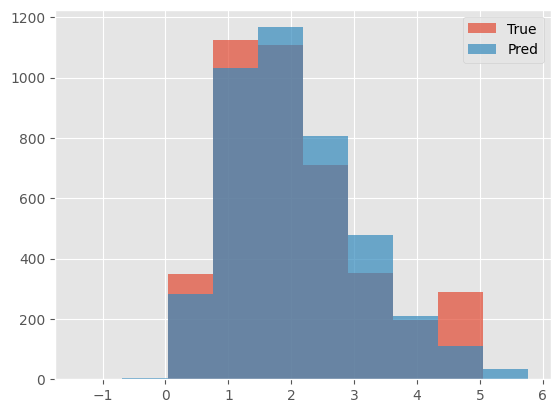

In [ ]:
fig, ax = plt.subplots()
hist_range = (min(Ytest.min(), test_pred.min()).item(), max(Ytest.max(), test_pred.max()).item())
ax.hist(Ytest.numpy(), bins=10, range=hist_range, alpha=0.7, label="True")
ax.hist(test_pred.numpy(), bins=10, range=hist_range, alpha=0.7, label="Pred")
ax.legend(loc="best")

## hyperparameter tuning

In [32]:
def mclass_loss(true, pred):
    true = torch.argmax(true, dim=1)
    pred = torch.argmax(pred, dim=1)
    return torch.mean((true != pred).to(torch.float32))
mclass_scorer = metrics.make_scorer(mclass_loss, greater_is_better=False)

In [35]:
parameter_grid = {
    'kernel': [falkon.kernels.GaussianKernel(sigma=1),
               falkon.kernels.GaussianKernel(sigma=5),
               falkon.kernels.GaussianKernel(sigma=10),
               falkon.kernels.GaussianKernel(sigma=15),],
    'penalty': [1e-5, 1e-7, 1e-9],
    'M': [500, 1000, 2000],
}
estimator = falkon.Falkon(
    kernel=falkon.kernels.GaussianKernel(1), penalty=1e-3, M=1000,  # Mandatory parameters, will be overridden
    maxiter=10, options=falkon.FalkonOptions(use_cpu=False))

grid_search = model_selection.GridSearchCV(estimator, parameter_grid, scoring=mclass_scorer, cv=5)

In [36]:
%%time
grid_search.fit(Xtrain, Ytrain)
print("The best parameters are: ", grid_search.best_params_)

ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/falkon-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ubuntu/miniconda3/envs/falkon-env/lib/python3.10/site-packages/falkon/models/falkon.py", line 213, in fit
    _use_cuda_mmv = self.use_cuda_ and tot_mmv_mem_usage / self.num_gpus >= get_min_cuda_mmv_size(
ZeroDivisionError: division by zero
